### Exercise 1: Mean Filter (Filtre moyenneur)
- Goal: Implement a mean filter to reduce noise and blur the image. The filter uses a sliding window where the new pixel value is the average of its neighbors.
- Theory:
    For a kernel parameter $k$, the window size is $(2k+1) \times (2k+1)$. 

    We must iterate over the image pixels and calculate the mean of the surrounding window.

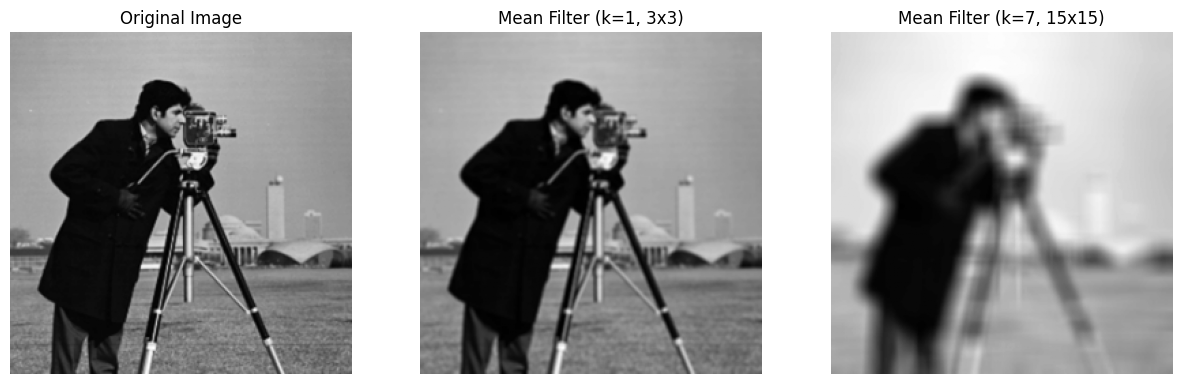

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def custom_mean_filter(image, k):
    h, w = image.shape
    # Calculate window size 
    window_size = 2 * k + 1
    
    # Pad the image to handle borders (replicate border)
    # allows the window to fit at the edges of the image
    padded_image = np.pad(image, k, mode='edge')
    
    # Initialize output image with zeros
    output_image = np.zeros((h, w), dtype=np.uint8)
    
    # Sliding window operation 
    for i in range(h):
        for j in range(w):
            # Extract the region of interest (ROI) from the padded image
            # The region is centered at (i+k, j+k) in the padded image
            region = padded_image[i:i+window_size, j:j+window_size]
            
            # Calculate the mean of the region 
            mean_val = np.mean(region)
            
            # Assign to output
            output_image[i, j] = int(mean_val)
            
    return output_image

# Test
img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)
# Apply the filter with k=1 (Window size 3x3)
filtered_img_k1 = custom_mean_filter(img, k=1)
# Apply the filter with k=7 (Window size 15x15) to see strong blurring
filtered_img_k7 = custom_mean_filter(img, k=7)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mean Filter (k=1, 3x3)")
plt.imshow(filtered_img_k1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Mean Filter (k=7, 15x15)")
plt.imshow(filtered_img_k7, cmap='gray')
plt.axis('off')

plt.show()

### Exercise 2: Convolution Product
- Goal: Implement a general convolution function convolution that takes an image and a specific kernel (mask) as input and computes the filtered image.
- Theory:Convolution generalizes the mean filter by using a weighted average. 
- The "sliding window" is now an image (kernel) containing weighting coefficients.
- The value of a pixel is the sum of the element-wise product of the image region and the kernel.
- While the mathematical definition involves flipping the kernel ($g(x-i, y-j)$) , the text notes this symmetry is "technical" and "doesn't really matter in practice". 

Therefore, we will implement the standard weighted sum (often called cross-correlation in libraries, but treated as convolution here)

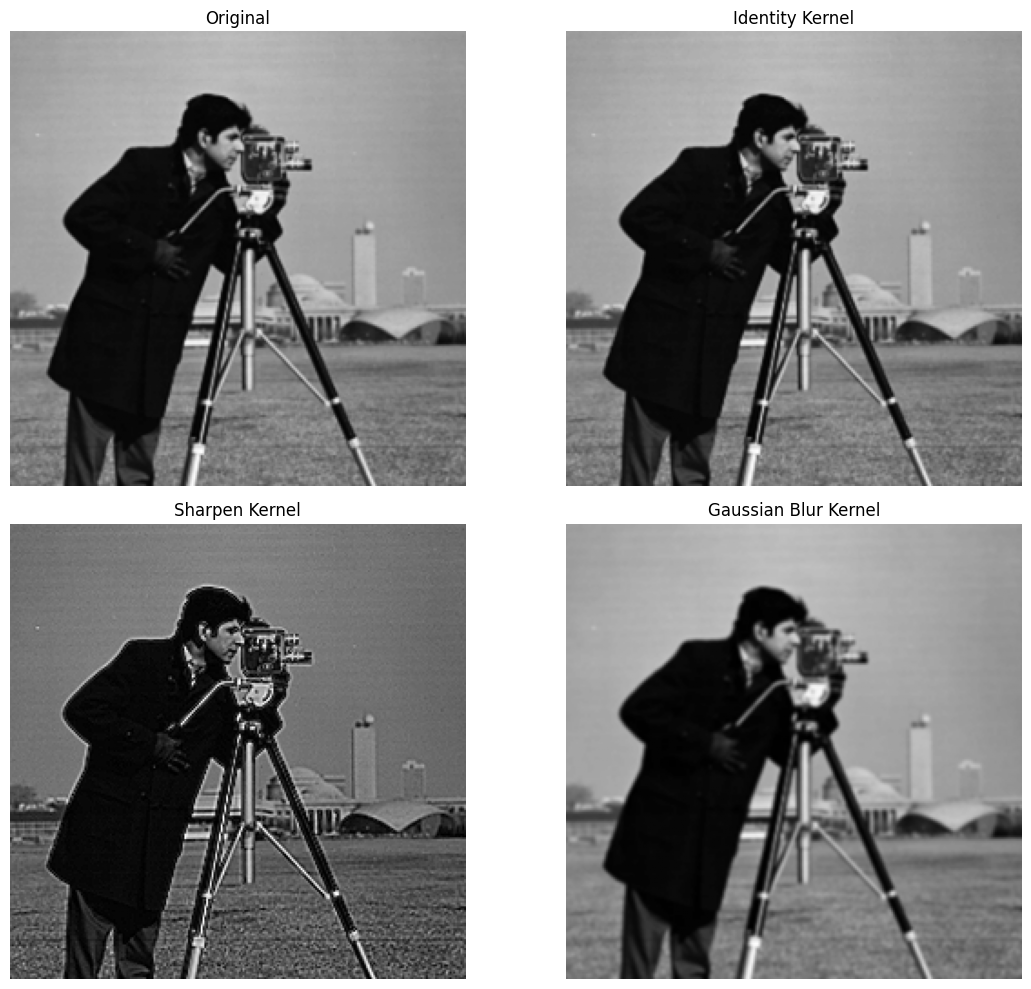

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convolution(image, kernel):
    h, w = image.shape
    # Get kernel dimensions
    kh, kw = kernel.shape
    
    # Calculate padding size ( odd kernel size)
    pad_h = kh // 2
    pad_w = kw // 2
    
    # Pad the image --> 'edge' mode to replicate border pixels
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # output image
    # use float to prevent overflow during intermediate calculations 
    output_image = np.zeros((h, w), dtype=np.float32)
    
    # Convolution loop
    for i in range(h):
        for j in range(w):
            # region of interest (ROI)
            region = padded_image[i:i+kh, j:j+kw]
            value = np.sum(region * kernel)
            output_image[i, j] = value
            
    # Post-processing: 
    output_image = np.abs(output_image)
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    
    return output_image

# test

# Load image
img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)

# 1. Identity Kernel (No change) 
kernel_identity = np.array([[0, 0, 0],
                            [0, 1, 0],
                            [0, 0, 0]])

# 2. Sharpen Kernel (Filtre réhausseur)
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

# 3. Gaussian Blur Kernel (Filtre gaussien 3x3) 
# Note: The sum of weights is 16, so we divide by 16.
kernel_gaussian = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]]) / 16.0

# convolutions
res_identity = convolution(img, kernel_identity)
res_sharpen = convolution(img, kernel_sharpen)
res_gaussian = convolution(img, kernel_gaussian)

# Display results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Identity Kernel")
plt.imshow(res_identity, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Sharpen Kernel")
plt.imshow(res_sharpen, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Gaussian Blur Kernel")
plt.imshow(res_gaussian, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### Exercise 3: Sobel Edge Detector
- Goal: Implement the Sobel edge detector to calculate the gradient norm of the image.
- Theory:
Edge detection works by finding areas of high variation (derivatives). 
Since images are discrete, we estimate derivatives using the gradient $\nabla f = (G_x, G_y)$.

The Sobel method defines two kernels to approximate these partial derivatives:
- Horizontal Gradient ($G_x$): detects vertical edges.

$$G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

- Vertical Gradient ($G_y$): detects horizontal edges.

$$G_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

The magnitude (norm) of the gradient is calculated as:
$$||\nabla f|| = \sqrt{G_x^2 + G_y^2}$$

Important Note on Implementation:the previous convolution function returns uint8 and takes the absolute value. However, derivatives can be negative (e.g., transition from white to black). We need the raw signed float values for $G_x$ and $G_y$ before combining them. 

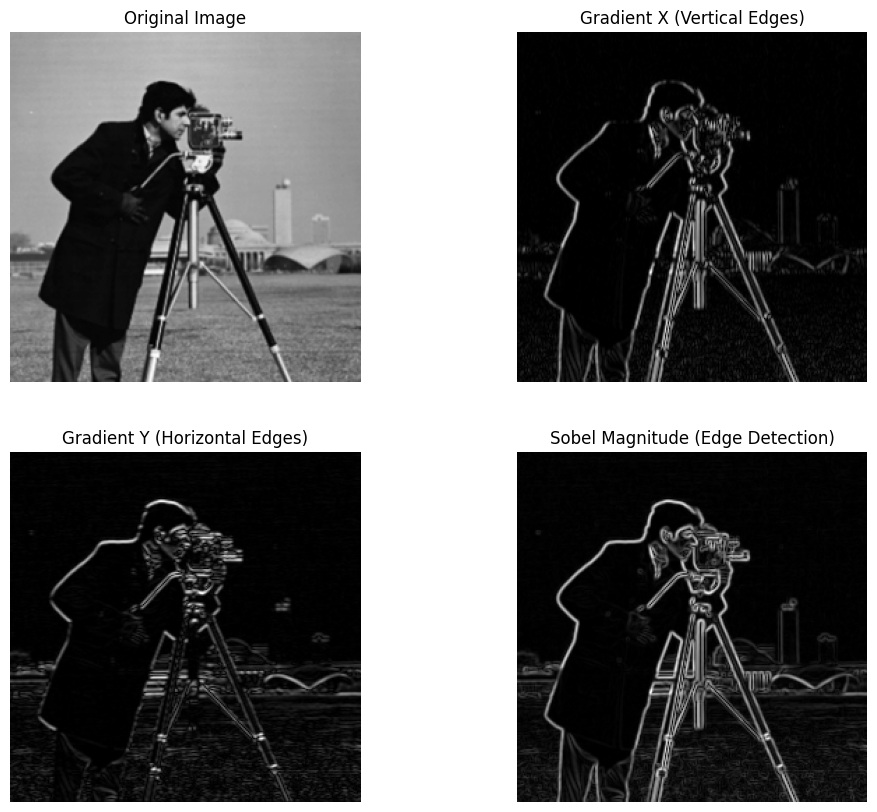

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def raw_convolution(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    output_image = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i+kh, j:j+kw]
            output_image[i, j] = np.sum(region * kernel)
            
    return output_image

def edge_sobel(image):
    Gx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])
    
    Gy_kernel = np.array([[ 1,  2,  1],
                          [ 0,  0,  0],
                          [-1, -2, -1]])
    
    # 1. Compute Partial Derivatives
    grad_x = raw_convolution(image, Gx_kernel)
    grad_y = raw_convolution(image, Gy_kernel)
    
    # 2. Compute Gradient Magnitude (Norm) 
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # 3. Normalize to 0-255 for display
    if gradient_magnitude.max() > 0:
        gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255
        
    return gradient_magnitude.astype(np.uint8), grad_x, grad_y

# test
img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)
# Apply Sobel
sobel_mag, g_x, g_y = edge_sobel(img)

# Display
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Gradient X (Vertical Edges)")


plt.imshow(np.abs(g_x), cmap='gray') 
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Gradient Y (Horizontal Edges)")
plt.imshow(np.abs(g_y), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Sobel Magnitude (Edge Detection)")
plt.imshow(sobel_mag, cmap='gray')
plt.axis('off')

plt.show()

### Exercise 4: Bilateral Filter
- Goal: Implement a bilateral filter. 
This filter smoothes images while preserving edges, unlike standard Gaussian blur which blurs everything equally.

- Theory: The bilateral filter replaces a pixel's value with a weighted average of its neighbors. The weight depends on two factors:

    1. Spatial distance: Pixels closer to the center pixel have higher weight (Gaussian distribution based on distance).


    2. Intensity difference (Range): Pixels with similar intensity to the center pixel have higher weight (Gaussian distribution based on intensity difference).

This prevents averaging across edges (where intensity difference is large), and so preserving them.

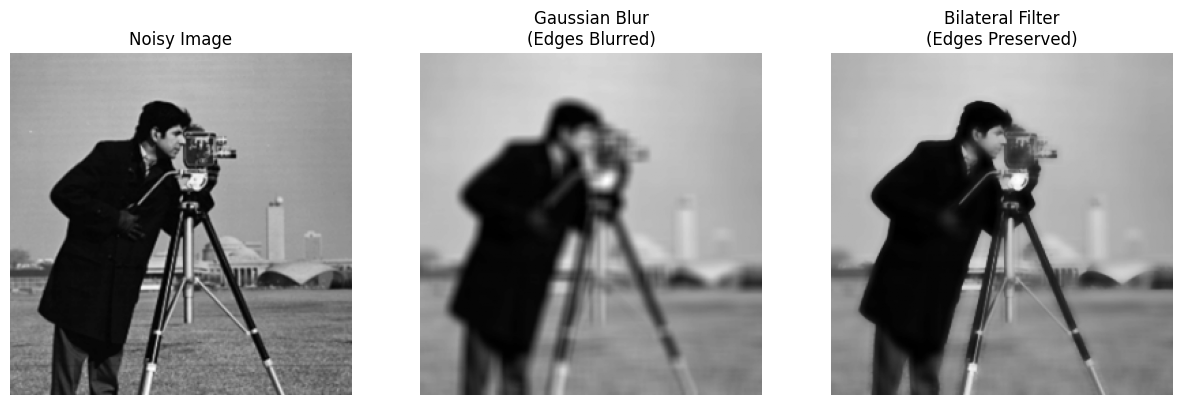

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, sigma):
    return (1.0 / (2 * np.pi * (sigma ** 2))) * np.exp(-(x ** 2) / (2 * (sigma ** 2)))

def distance(x, y, i, j):
    return np.sqrt((x - i) ** 2 + (y - j) ** 2)

def bilateral_filter(image, d, sigma_color, sigma_space):
    h, w = image.shape
    output_image = np.zeros((h, w), dtype=np.float32)
    
    # Pad image to handle borders
    radius = d // 2
    padded_image = np.pad(image, radius, mode='edge').astype(np.float32)
    
    # Precompute spatial gaussian weights because they are constant for a given window size
    spatial_weights = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            spatial_weights[i, j] = gaussian(distance(i, j, radius, radius), sigma_space)
            
    # Iterate over every pixel
    for i in range(h):
        for j in range(w):
            # Extract local region
            region = padded_image[i:i+d, j:j+d]
            
            # Center pixel value
            center_val = padded_image[i+radius, j+radius]
            
            # Compute range weights (intensity difference)
            # has to be done per pixel because it depends on the image content
            range_weights = gaussian(region - center_val, sigma_color)
            
            # Combine weights
            total_weights = spatial_weights * range_weights
            
            # Normalize and assign
            normalization = np.sum(total_weights)
            output_image[i, j] = np.sum(total_weights * region) / normalization
            
    return output_image.astype(np.uint8)

# test 
img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)


# Apply Bilateral Filter
# d=9, sigma_color=50, sigma_space=50 are common starting values
filtered_bilateral = bilateral_filter(img, d=9, sigma_color=50, sigma_space=50)

# Apply Standard Gaussian Blur for comparison (using OpenCV)
filtered_gaussian = cv2.GaussianBlur(img, (9, 9), 50)

# Display results
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Noisy Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Gaussian Blur\n(Edges Blurred)")
plt.imshow(filtered_gaussian, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Bilateral Filter\n(Edges Preserved)")
plt.imshow(filtered_bilateral, cmap='gray')
plt.axis('off')

plt.show()

### Exercise 5: Median Filter (Filtre médian)
- Goal: Implement a median filter. This is a non-linear filter that is particularly effective at removing "salt and pepper" noise (random black and white pixels) while preserving edges better than a mean filter.

- Theory: Unlike convolution, which calculates a weighted sum, the median filter considers the statistical distribution of pixel intensities within the window.
- Collect: Gather all pixel values in the $(2k+1) \times (2k+1)$ window centered on the pixel.Sort: Sort these values in ascending order.
- Select: Pick the median value (the middle element of the sorted list) and assign it to the center pixel.
- For example, if the values in a $3\times3$ window are $\{1, 3, 6, 9, 223\}$, the mean is $48.4$ (skewed by the outlier 223), but the median is $6$, which represents the background better

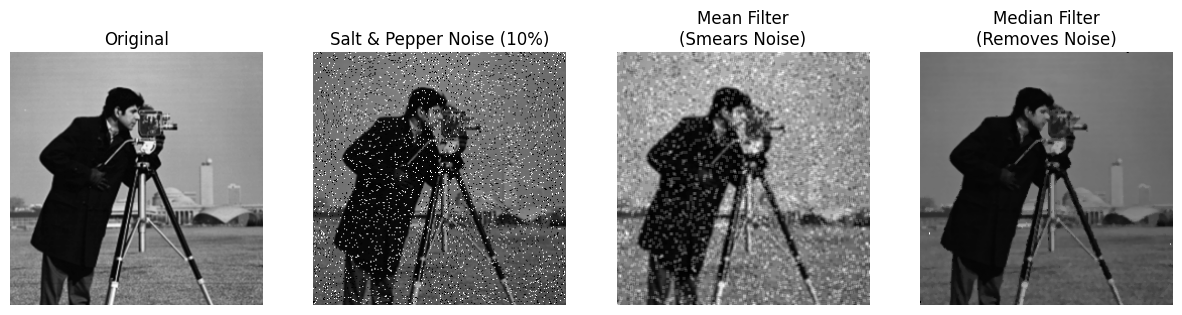

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def custom_median_filter(image, k):

    h, w = image.shape
    window_size = 2 * k + 1
    pad = k
    
    # Pad image to handle borders
    padded_image = np.pad(image, pad, mode='edge')
    
    output_image = np.zeros((h, w), dtype=np.uint8)
    
    # Sliding window operation
    for i in range(h):
        for j in range(w):
            # Extract region
            region = padded_image[i:i+window_size, j:j+window_size]
            
            # Flatten the 2D region to a 1D array
            pixels = region.flatten()
            
            # Calculate median
            median_val = np.median(pixels)

            output_image[i, j] = int(median_val)
            
    return output_image

def add_salt_and_pepper_noise(image, amount=0.05):

    row, col = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[tuple(coords)] = 255

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[tuple(coords)] = 0
    return out

#test

# Load image
img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    img = np.zeros((200, 200), dtype=np.uint8)
    cv2.circle(img, (100, 100), 50, 255, -1)

# Corrupt the image with Salt & Pepper noise
noisy_img = add_salt_and_pepper_noise(img, amount=0.1)

# Apply Median Filter (k=1 -> 3x3 window)
denoised_median = custom_median_filter(noisy_img, k=1)

# Apply Mean Filter (from Exercise 1) for comparison
denoised_mean = cv2.blur(noisy_img, (3, 3)) 

# Display results
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Salt & Pepper Noise (10%)")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mean Filter\n(Smears Noise)")
plt.imshow(denoised_mean, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Median Filter\n(Removes Noise)")
plt.imshow(denoised_median, cmap='gray')
plt.axis('off')

plt.show()